## Extracting the Dataset for CSV

In [ ]:
import zipfile
from pathlib import Path

# --- SETTINGS ---
dataset_zip = Path("dataset/PAMANA_Dataset.zip")  # top-level zip file
extract_root = Path("input")                      # where to unpack
extract_root.mkdir(exist_ok=True)

# --- STEP 1: Extract the top-level zip ---
print(f"Extracting: {dataset_zip}")
with zipfile.ZipFile(dataset_zip, "r") as z:
    z.extractall(extract_root)

# --- STEP 2: Recursively extract nested zips and delete them afterward ---
for inner_zip in extract_root.rglob("*.zip"):
    target_dir = inner_zip.parent / inner_zip.stem
    target_dir.mkdir(exist_ok=True)
    print(f"Extracting {inner_zip} -> {target_dir}")

    try:
        with zipfile.ZipFile(inner_zip, "r") as z:
            z.extractall(target_dir)
        inner_zip.unlink()  # delete the zip file after successful extraction
    except zipfile.BadZipFile as e:
        print(f"⚠️ Skipped bad zip {inner_zip}: {e}")

print("\n✅ All nested zips extracted and originals deleted!")

## Reading the Dataset for CSV

In [12]:
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# --- SETTINGS ---
DATA_DIR = Path("input")                 # root folder containing instrument folders
OUTPUT_CSV = "pamana_dataset.csv"
AUDIO_EXTS = {".wav", ".mp3", ".flac", ".ogg", ".m4a", ".aac", ".wma"}

# --- Feature extraction helper ---
def extract_audio_metadata(file_path: Path) -> dict | None:
    """
    Load one audio file and return basic metadata:
    sample rate, duration, file type, and inferred instrument label.
    """
    try:
        # Load audio (mono)
        y, sr = librosa.load(file_path, sr=None, mono=True)
        duration = librosa.get_duration(y=y, sr=sr)

        # Infer instrument label from parent folder (e.g., 'Agung_audios' -> 'Agung')
        parent_folder = file_path.parent.name
        instrument_label = parent_folder.replace("_audios", "")

        return {
            "filepath": str(file_path),
            "filetype": file_path.suffix.lower(),
            "sample_rate": sr,
            "duration_sec": duration,
            "instrument_label": instrument_label,
        }

    except Exception as e:
        print(f"⚠️ Skipped {file_path}: {e}")
        return None


# --- Collect all supported audio files ---
audio_files = [f for f in DATA_DIR.rglob("*") if f.suffix.lower() in AUDIO_EXTS]
print(f"Found {len(audio_files)} audio files in {DATA_DIR.resolve()}.")

# --- Extract metadata with progress bar ---
records: list[dict] = []
for f in tqdm(audio_files, desc="Extracting metadata"):
    info = extract_audio_metadata(f)
    if info:
        records.append(info)

# --- Save to CSV ---
df = pd.DataFrame(records)
if not df.empty:
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n✅ Metadata extraction complete.")
    print(f"Saved {len(df)} rows to '{OUTPUT_CSV}'.\n")
    print("Instrument distribution:")
    print(df["instrument_label"].value_counts())
else:
    print("\n⚠️ No features extracted — check your input path and file formats.")

Found 670 audio files in C:\Users\creep\Documents\Programs\Third_Year\Project_PAMANA_dataset\input.


Extracting metadata: 100%|██████████| 670/670 [00:27<00:00, 23.94it/s]


✅ Metadata extraction complete.
Saved 670 rows to 'pamana_dataset.csv'.

Instrument distribution:
instrument_label
Gabbang                        70
Faglung                        54
Labil                          39
Agung (Panay Bukidnon)         34
Tumpong                        31
Subing                         30
Bombo                          28
Tambor                         26
Kubing                         24
Tambol                         24
Agung (Subanen)                24
Kalaleng (Besao Fieldwork)     24
Tacombo                        24
Tanangong                      21
Ab-bew                         20
Kalaleng (Bontoc Fieldwork)    19
Tikumbo                        18
Abistung                       17
Agung (Mansaka)                17
Gimbao                         16
Paratikan                      16
Kuging                         16
Suganggang                     11
Patik-patik                    11
Subing (Panay Bukidnon)        10
Banjo                          10


In [21]:
import polars as pl

df = pl.read_csv("pamana_dataset.csv")

df.describe()

statistic,filepath,filetype,sample_rate,duration_sec,instrument_label
str,str,str,f64,f64,str
"""count""","""670""","""670""",670.0,670.0,"""670"""
"""null_count""","""0""","""0""",0.0,0.0,"""0"""
"""mean""",null,null,44100.0,7.01957,null
"""std""",null,null,0.0,20.930983,null
"""min""","""input\PAMANA_Dataset\Luzon\Ab-…",""".mp3""",44100.0,0.287347,"""Ab-bew"""
"""25%""",null,null,44100.0,0.992653,null
"""50%""",null,null,44100.0,1.306122,null
"""75%""",null,null,44100.0,3.526531,null
"""max""","""input\PAMANA_Dataset\Visayas\T…",""".mp3""",44100.0,250.514286,"""Tumpong"""


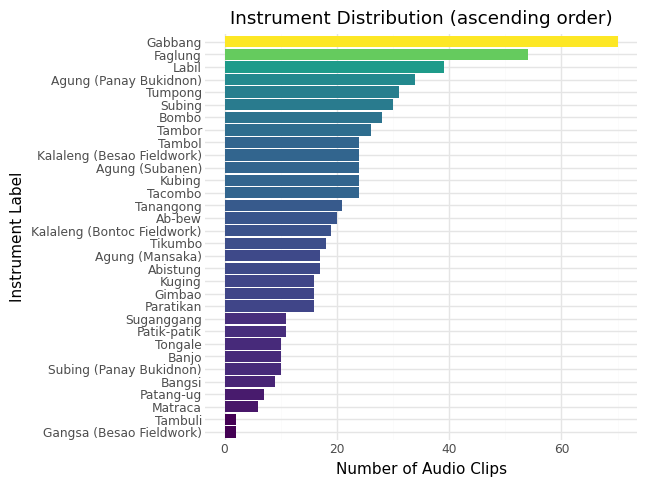

In [20]:
import pandas as pd
from plotnine import (
    ggplot, aes, geom_bar, coord_flip, labs,
    theme_minimal, scale_fill_cmap
)

# Load your metadata
df = pd.read_csv("pamana_dataset.csv")

# --- aggregate number of clips per instrument ---
counts = (
    df.groupby("instrument_label")
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=True)       # Ascending!
)

# --- preserve that order for plotting ---
counts["instrument_label"] = pd.Categorical(
    counts["instrument_label"],
    categories=counts["instrument_label"],        # order as just sorted
    ordered=True
)

# --- build the plot ---
bar_plot = (
    ggplot(counts, aes(x="instrument_label", y="count", fill="count"))
    + geom_bar(stat="identity", show_legend=False)
    + coord_flip()
    + scale_fill_cmap(name="viridis")             # nice gradient color
    + labs(
        title="Instrument Distribution (ascending order)",
        x="Instrument Label",
        y="Number of Audio Clips"
    )
    + theme_minimal()
)

bar_plot

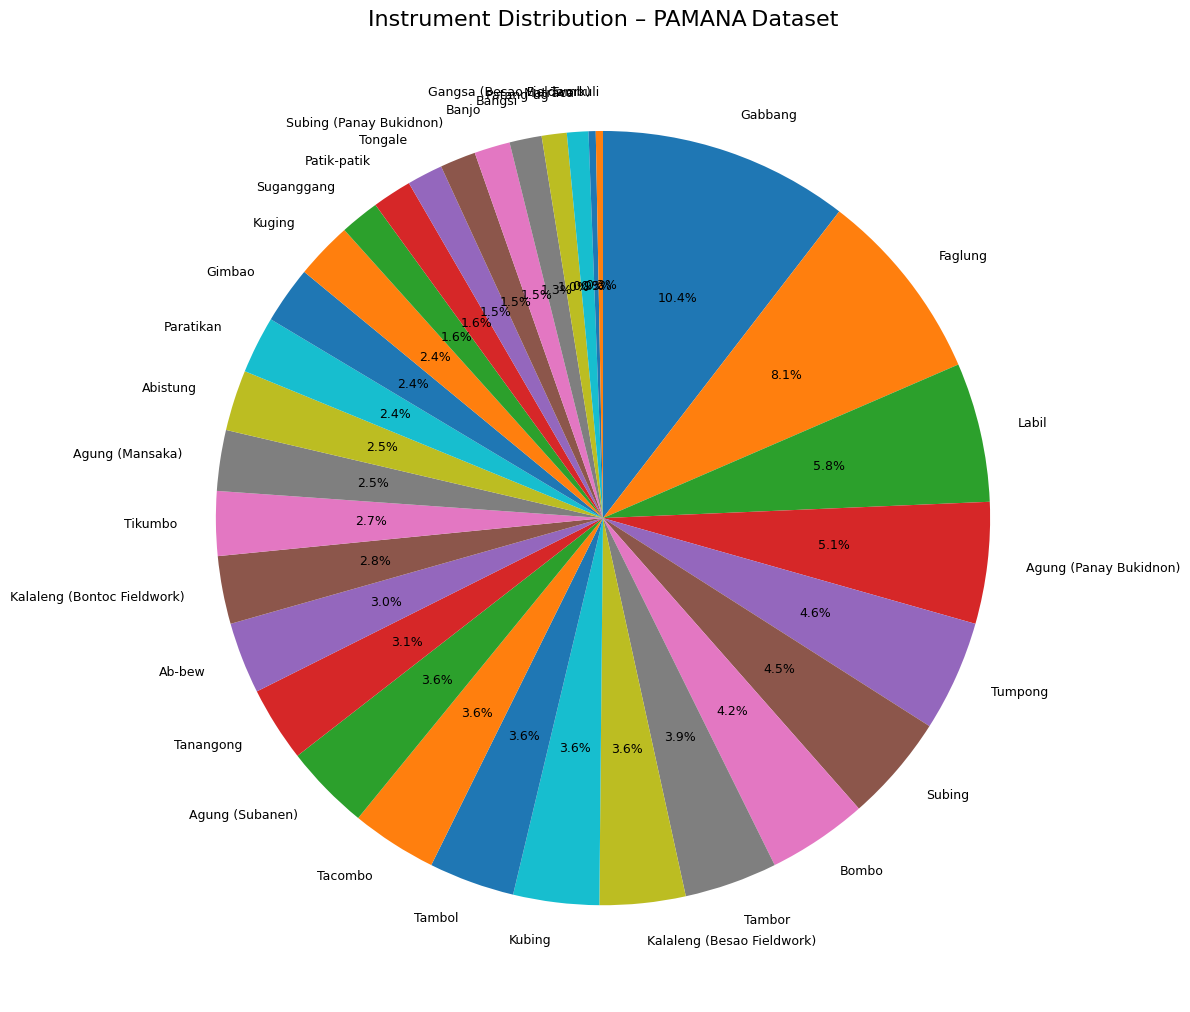

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and aggregate
df = pd.read_csv("pamana_dataset.csv")
counts = (
    df.groupby("instrument_label")
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)

# Make the figure larger (12 × 12 inches here)
fig, ax = plt.subplots(figsize=(12, 12))

# Pie chart
wedges, texts, autotexts = ax.pie(
    counts["count"],
    labels=counts["instrument_label"],
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False,
    textprops={"fontsize": 9}          # smaller font per slice
)

ax.set_title("Instrument Distribution – PAMANA Dataset", fontsize=16)
plt.tight_layout()
plt.show()